In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Statsmodels is a library for estimating and interpreting statistical models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing 
from statsmodels.tsa.seasonal import seasonal_decompose
import math      

In [2]:
#Import the dataset for Malin Head
time_series = pd.read_csv('data/hourly_data/hly1575.csv', skiprows=23,skipinitialspace=True, index_col=False, low_memory=False)

#Rename the columns
time_series.columns = ['Date/Time (utc)', 'Indicator', 'Precipitation Amount (mm)', 'Indicator', 'Temperature (°C)', 'Indicator', 'Wet Bulb Temperature (°C)', 'Dew Point Temp (°C)', 'Vapour Pressure (hPa)','Relative Humidity (%)', 'Mean Sea Level Pressure (hPa)','Indicator', 'Mean Wind Speed (knot)', 'Indicator', 'Predominant Wind Direction (deg)', 'Present Weather', 'Past Weather', 'Sunshine duration (hours)', 'Visibility', 'Cloud Height (ft * 100s)', 'Cloud amount']

#Format the date column as a datetime object
time_series['Date/Time (utc)'] = pd.to_datetime(time_series['Date/Time (utc)'], format='%d-%b-%Y %H:%M')

#Add a year and month column
time_series['Year'] = time_series['Date/Time (utc)'].dt.year
time_series['Month'] = time_series['Date/Time (utc)'].dt.month

#Convert the windspeed data to km/h
time_series['Mean Wind Speed (m/s)'] = time_series['Mean Wind Speed (knot)'] * 0.514444

#Select just the columns we are interested in
time_series = time_series[['Date/Time (utc)','Mean Wind Speed (m/s)', 'Month', 'Year']]



#Convert the Date/Time column to a datetime object.
time_series['Date/Time (utc)'] = pd.to_datetime(time_series['Date/Time (utc)'], format='%d-%b-%Y %H:%M')

#Set the Date/Time column as the index
time_series.set_index('Date/Time (utc)', inplace=True)

#Have a quick look at our data to see if it has been loaded correctly
time_series.head()


,Mean Wind Speed (m/s),Month,Year
Date/Time (utc),,,
1955-05-01 01:00:00,5.658884,5,1955
1955-05-01 02:00:00,5.658884,5,1955
1955-05-01 03:00:00,4.115552,5,1955
1955-05-01 04:00:00,9.259992,5,1955
1955-05-01 05:00:00,4.629996,5,1955


In [3]:
# Check for missing values
print(time_series.isnull().sum())

Mean Wind Speed (m/s)    52
Month                     0
Year                      0
dtype: int64


In [4]:
#Average wind for the entire year
time_series= time_series['Mean Wind Speed (m/s)'].resample('ME').mean().reset_index(name='Average Wind Speed (m/s)')

time_series.dropna(inplace=True)

#Set the Date/Time column as the index
time_series.set_index('Date/Time (utc)', inplace=True)

time_series.asfreq('ME')

time_series.head()

,Average Wind Speed (m/s)
Date/Time (utc),
1955-05-31,7.506867
1955-06-30,6.619179
1955-07-31,3.207669
1955-08-31,4.179857
1955-09-30,8.247538


In [5]:
# ADF Test for stationarity
result = adfuller(time_series['Average Wind Speed (m/s)'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -3.6700407716343144
p-value: 0.004554845478040679


In [17]:
#Define our features and target
y = time_series['Average Wind Speed (m/s)'].asfreq('ME')

X = time_series.index

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Assuming p=1, d=1, q=1 based on the previous steps (you'll adjust these)
p, d, q = 1, 1, 1

model = ARIMA(time_series['Average Wind Speed (m/s)'], order=(p, d, q), freq='ME')
#p = number of AR terms, d = number of differences, q = number of MA terms
#AR = autoregressive terms, which defines the relationship between an observation and a number of lagged observations
#MA = moving average terms, which defines the relationship between an observation and a residual error 
#from a moving average model applied to lagged observations
model_fit = model.fit()



ARIMA - Mean Squared Error: 2.409480121248362
ARIMA - Mean Absolute Error: 1.263142139133743
ARIMA - R-squared: -0.0371948247987719


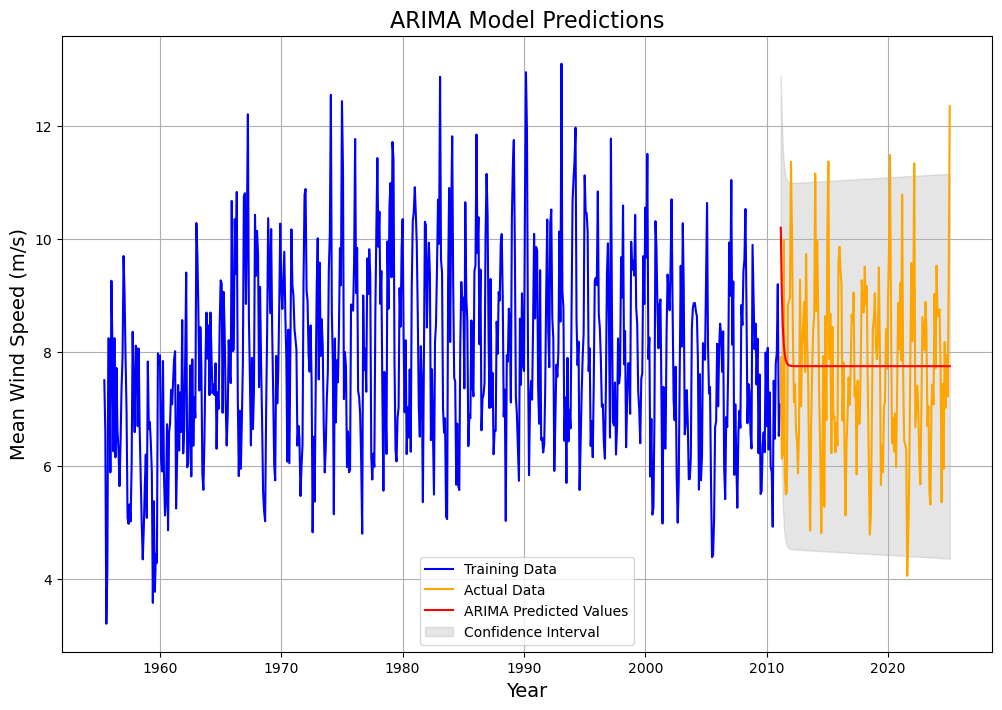

In [14]:
# Make predictions
#Generate predictions for the test set
y_pred = model_fit.get_forecast(steps=len(y_test))

#Retreive the confidence intervals for predictions of 95% confidence levels
y_pred_df = y_pred.conf_int(alpha=0.05)

#Add the predictions 
y_pred_df['pred'] = y_pred.predicted_mean

#Align the predictions with the test set
y_pred_df.index = y_test.index

#Extract predicted values
y_pred = y_pred_df['pred']

# Calculate the mean squared error and R-squared value
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Print the results
print(f'ARIMA - Mean Squared Error: {mse}')
print(f'ARIMA - Mean Absolute Error: {mae}')
print(f'ARIMA - R-squared: {r2}')

#Plot the predictions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
# Plot the training data, test data, and predicted values
ax.plot(y_train.index, y_train, label='Training Data', color='blue')
ax.plot(y_test.index, y_test, label='Actual Data', color='orange')
ax.plot(y_pred.index, y_pred, label='ARIMA Predicted Values', color='red')
ax.fill_between(y_pred_df.index, y_pred_df.iloc[:, 0], y_pred_df.iloc[:, 1], color='gray', alpha=0.2, label='Confidence Interval')


# Set the title and labels
plt.title('ARIMA Model Predictions', fontdict=font1)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Wind Speed (m/s)', fontsize=14)
# Add a legend
plt.legend()
#Add a grid
plt.grid()


